In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
def preprocess_signature(image):
    # Convert RGB image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Noise reduction
    image_blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Thresholding
    _, image_thresh = cv2.threshold(image_blurred, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Normalization
    image_normalized = image_thresh / 255.0

    # Expand dimensions to make it compatible with VGG16 input shape
    image_normalized = np.expand_dims(image_normalized, axis=-1)
    image_normalized = np.repeat(image_normalized, 3, axis=-1)  # Repeat grayscale channel to create 3 channels

    return image_normalized


In [3]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

flatten_layer = Flatten()(base_model.output)

dense_layer = Dense(units=256, activation='relu')(flatten_layer)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(units=1, activation='sigmoid')(dropout_layer)

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


In [4]:
real_path = '/content/drive/MyDrive/JETTI PROJECTS/MINI project/Data collection /Swathi from 31-40/genuine'
forge_path = '/content/drive/MyDrive/JETTI PROJECTS/MINI project/Data collection /Swathi from 31-40/forged'
img_size = (224, 224)

real_images = []
for img_name in os.listdir(real_path):
    img = cv2.imread(os.path.join(real_path, img_name))
    img = cv2.resize(img, img_size)
    img = preprocess_signature(img)
    real_images.append(img)

forge_images = []
for img_name in os.listdir(forge_path):
    img = cv2.imread(os.path.join(forge_path, img_name))
    img = cv2.resize(img, img_size)
    img = preprocess_signature(img)
    forge_images.append(img)

real_labels = np.zeros(len(real_images))
forge_labels = np.ones(len(forge_images))

X_data = np.concatenate((real_images, forge_images), axis=0)
y_labels = np.concatenate((real_labels, forge_labels), axis=0)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_labels, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train)


In [6]:
history=model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")


Epoch 1/30
9/9 [==============================] - 18s 652ms/step - loss: 1.9555 - accuracy: 0.5731 - val_loss: 1.6240 - val_accuracy: 0.5000
Epoch 2/30
9/9 [==============================] - 4s 378ms/step - loss: 0.9470 - accuracy: 0.6077 - val_loss: 0.7209 - val_accuracy: 0.5152
Epoch 3/30
9/9 [==============================] - 4s 383ms/step - loss: 0.8547 - accuracy: 0.6154 - val_loss: 0.6217 - val_accuracy: 0.6364
Epoch 4/30
9/9 [==============================] - 5s 664ms/step - loss: 0.6946 - accuracy: 0.6077 - val_loss: 0.6326 - val_accuracy: 0.5909
Epoch 5/30
9/9 [==============================] - 4s 381ms/step - loss: 0.6199 - accuracy: 0.6423 - val_loss: 0.6168 - val_accuracy: 0.6364
Epoch 6/30
9/9 [==============================] - 3s 376ms/step - loss: 0.6307 - accuracy: 0.6462 - val_loss: 0.6043 - val_accuracy: 0.6667
Epoch 7/30
9/9 [==============================] - 4s 465ms/step - loss: 0.6044 - accuracy: 0.6500 - val_loss: 0.6005 - val_accuracy: 0.6212
Epoch 8/30
9/9 [===

In [7]:
model.save("/content/drive/MyDrive/JETTI PROJECTS/MINI project/Trained_model_files/VGG16_team_dataset_56.06%.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
import matplotlib.pyplot as plt


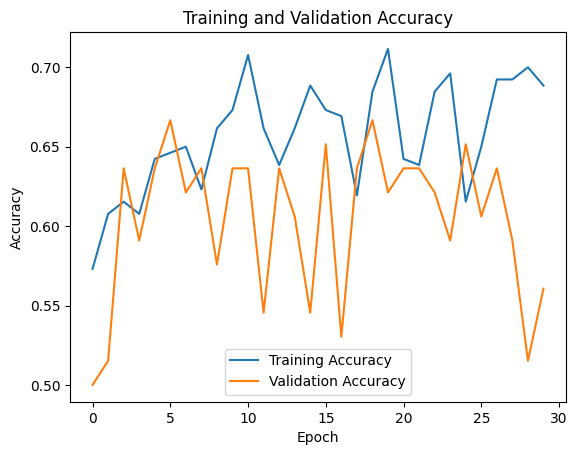

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


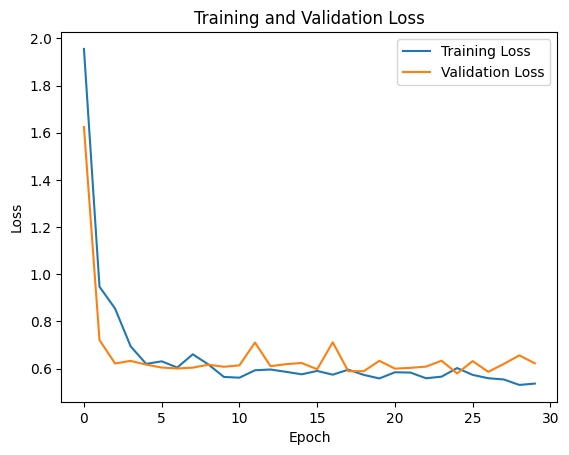

In [10]:

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

3/3 [==============================] - 1s 142ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.70      0.61        33
           1       0.58      0.42      0.49        33

    accuracy                           0.56        66
   macro avg       0.57      0.56      0.55        66
weighted avg       0.57      0.56      0.55        66



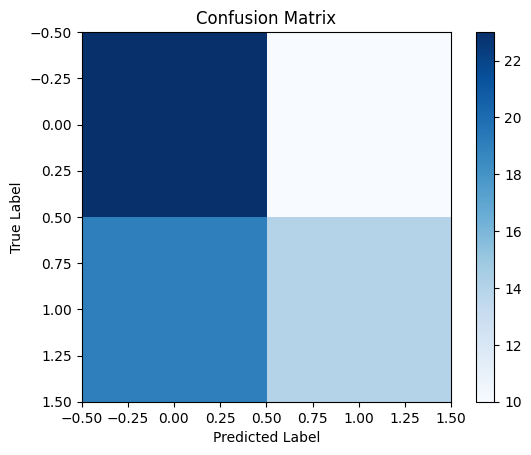

In [11]:
from sklearn.metrics import classification_report, confusion_matrix


# Predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).astype(int)

# Convert the labels to integers directly
y_test_int = np.array(y_test, dtype=int)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_int, y_pred_classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_int, y_pred_classes)
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


forge images

/content/drive/MyDrive/JETTI PROJECTS/MINI project/final collected data set/forged/IMG-20240213-WA0091.jpg /content/drive/MyDrive/JETTI PROJECTS/MINI project/final collected data set/forged/IMG-20240213-WA0090.jpg /content/drive/MyDrive/JETTI PROJECTS/MINI project/final collected data set/forged/IMG-20240213-WA0098.jpg /content/drive/MyDrive/JETTI PROJECTS/MINI project/final collected data set/forged/IMG-20240213-WA0109.jpg

real images

/content/drive/MyDrive/JETTI PROJECTS/MINI project/final collected data set/genuine/05403054.jpg

/content/drive/MyDrive/JETTI PROJECTS/MINI project/final collected data set/genuine/05404054.jpg

/content/drive/MyDrive/JETTI PROJECTS/MINI project/final collected data set/genuine/05603056.jpg

/content/drive/MyDrive/JETTI PROJECTS/MINI project/final collected data set/genuine/05702057.jpg

In [16]:
import cv2
import numpy as np

# Function to preprocess a single image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Adjust the size according to your model's input size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Path to the single image for testing
image_path = '/content/drive/MyDrive/JETTI PROJECTS/MINI project/final collected data set/genuine/05403054.jpg'
# Preprocess the single image
image = preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Convert the prediction to a binary result
result = "Forged" if prediction[0][0] > 0.5 else "Genuine"

# Print the result
print(f"The signature is predicted as: {result}")


1/1 [==============================] - 0s 38ms/step
The signature is predicted as: Forged


In [15]:
import cv2
import numpy as np

# Function to preprocess a single image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Adjust the size according to your model's input size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Path to the single image for testing
image_path = '/content/drive/MyDrive/JETTI PROJECTS/MINI project/final collected data set/forged/IMG-20240213-WA0090.jpg'
# Preprocess the single image
image = preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Convert the prediction to a binary result
result = "Forged" if prediction[0][0] > 0.5 else "Genuine"

# Print the result
print(f"The signature is predicted as: {result}")


1/1 [==============================] - 0s 32ms/step
The signature is predicted as: Forged
